**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [28]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.


In [29]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

zsh:1: command not found: gdown


In [30]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [31]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

For our specific example, fit_on_texts takes the list of strings "messages" and updates state variables of the Tokenizer object. Broadly, it counts the frequency of each word in all of the texts in "messages" and for each word, it counts the number of texts where the word appears at least once. After going through all the texts and recording this information, the data is sorted in descending order of frequencies. Then, it forms the dictionary self.word_index whose key is a word and it's value is the words order in descending order (i.e. most frequent word has key equal to the word and value equal to 1). A similar dictionary self.index_word is formed with the opposite relationship where the key is the order of the word when sorted in decreasing order and the value is the word itself (i.e. most frequent word has key = 1 and value equal to the word itself). Another dictionary is formed, self.index_docs whose keys are equal to the order of the word when sorted in decreasing order and the value is the number of documents that word occurs in at least once (i.e. most frequent word has key = 1 and value equal to the number of documents that the word appears at least once).

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

For our example, it converts each string in our list of strings "messages" into a list of integers. Using the previously defined vocabulary and dictionary of frequencies created in fit_on_texts, the integers in the list of integers representation refers to the order of the word when sorted by frequency in decreasing order. So, in the list of integers generated by texts_to_sequences, we'd expect very frequent words like the, and, and it to have low integer values. This also only considers max_vocab most frequent words so infrequent words are instead represented by a default value called oov_token_index.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

pad_sequences takes our list of sequences from texts_to_sequences and normalizes it such that they are all of the same length. Before this, each sequence (list of integers) is equal to the length of the original string which it represents. In our function call, we also specify a max_length so all sequences will be truncated and padded from the front until they reach that length.

This step is required because our model has a specified input size so all inputs must be normalized to fit.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [32]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [33]:
print(messages_train[0], labels_train[0])
print('Maximum Specified Length:',max_len,'Length of message',len(messages_train[0]))

[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586    9   36    1
  454 

Yes, this matches with what I expected. Each element in the training set is a sequence of integers with normalized length equal to max_len.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [34]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

`__init__` works by creating a state variable of a matrix of weights called `w`. This matrix of weights is represented by an objax trainable variable of size size x latent. The weights are initialized by a given callable or by the default `objax.nn.init.xavier_truncated_normal`.

`__call__` works by returing the x'th row given input x.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

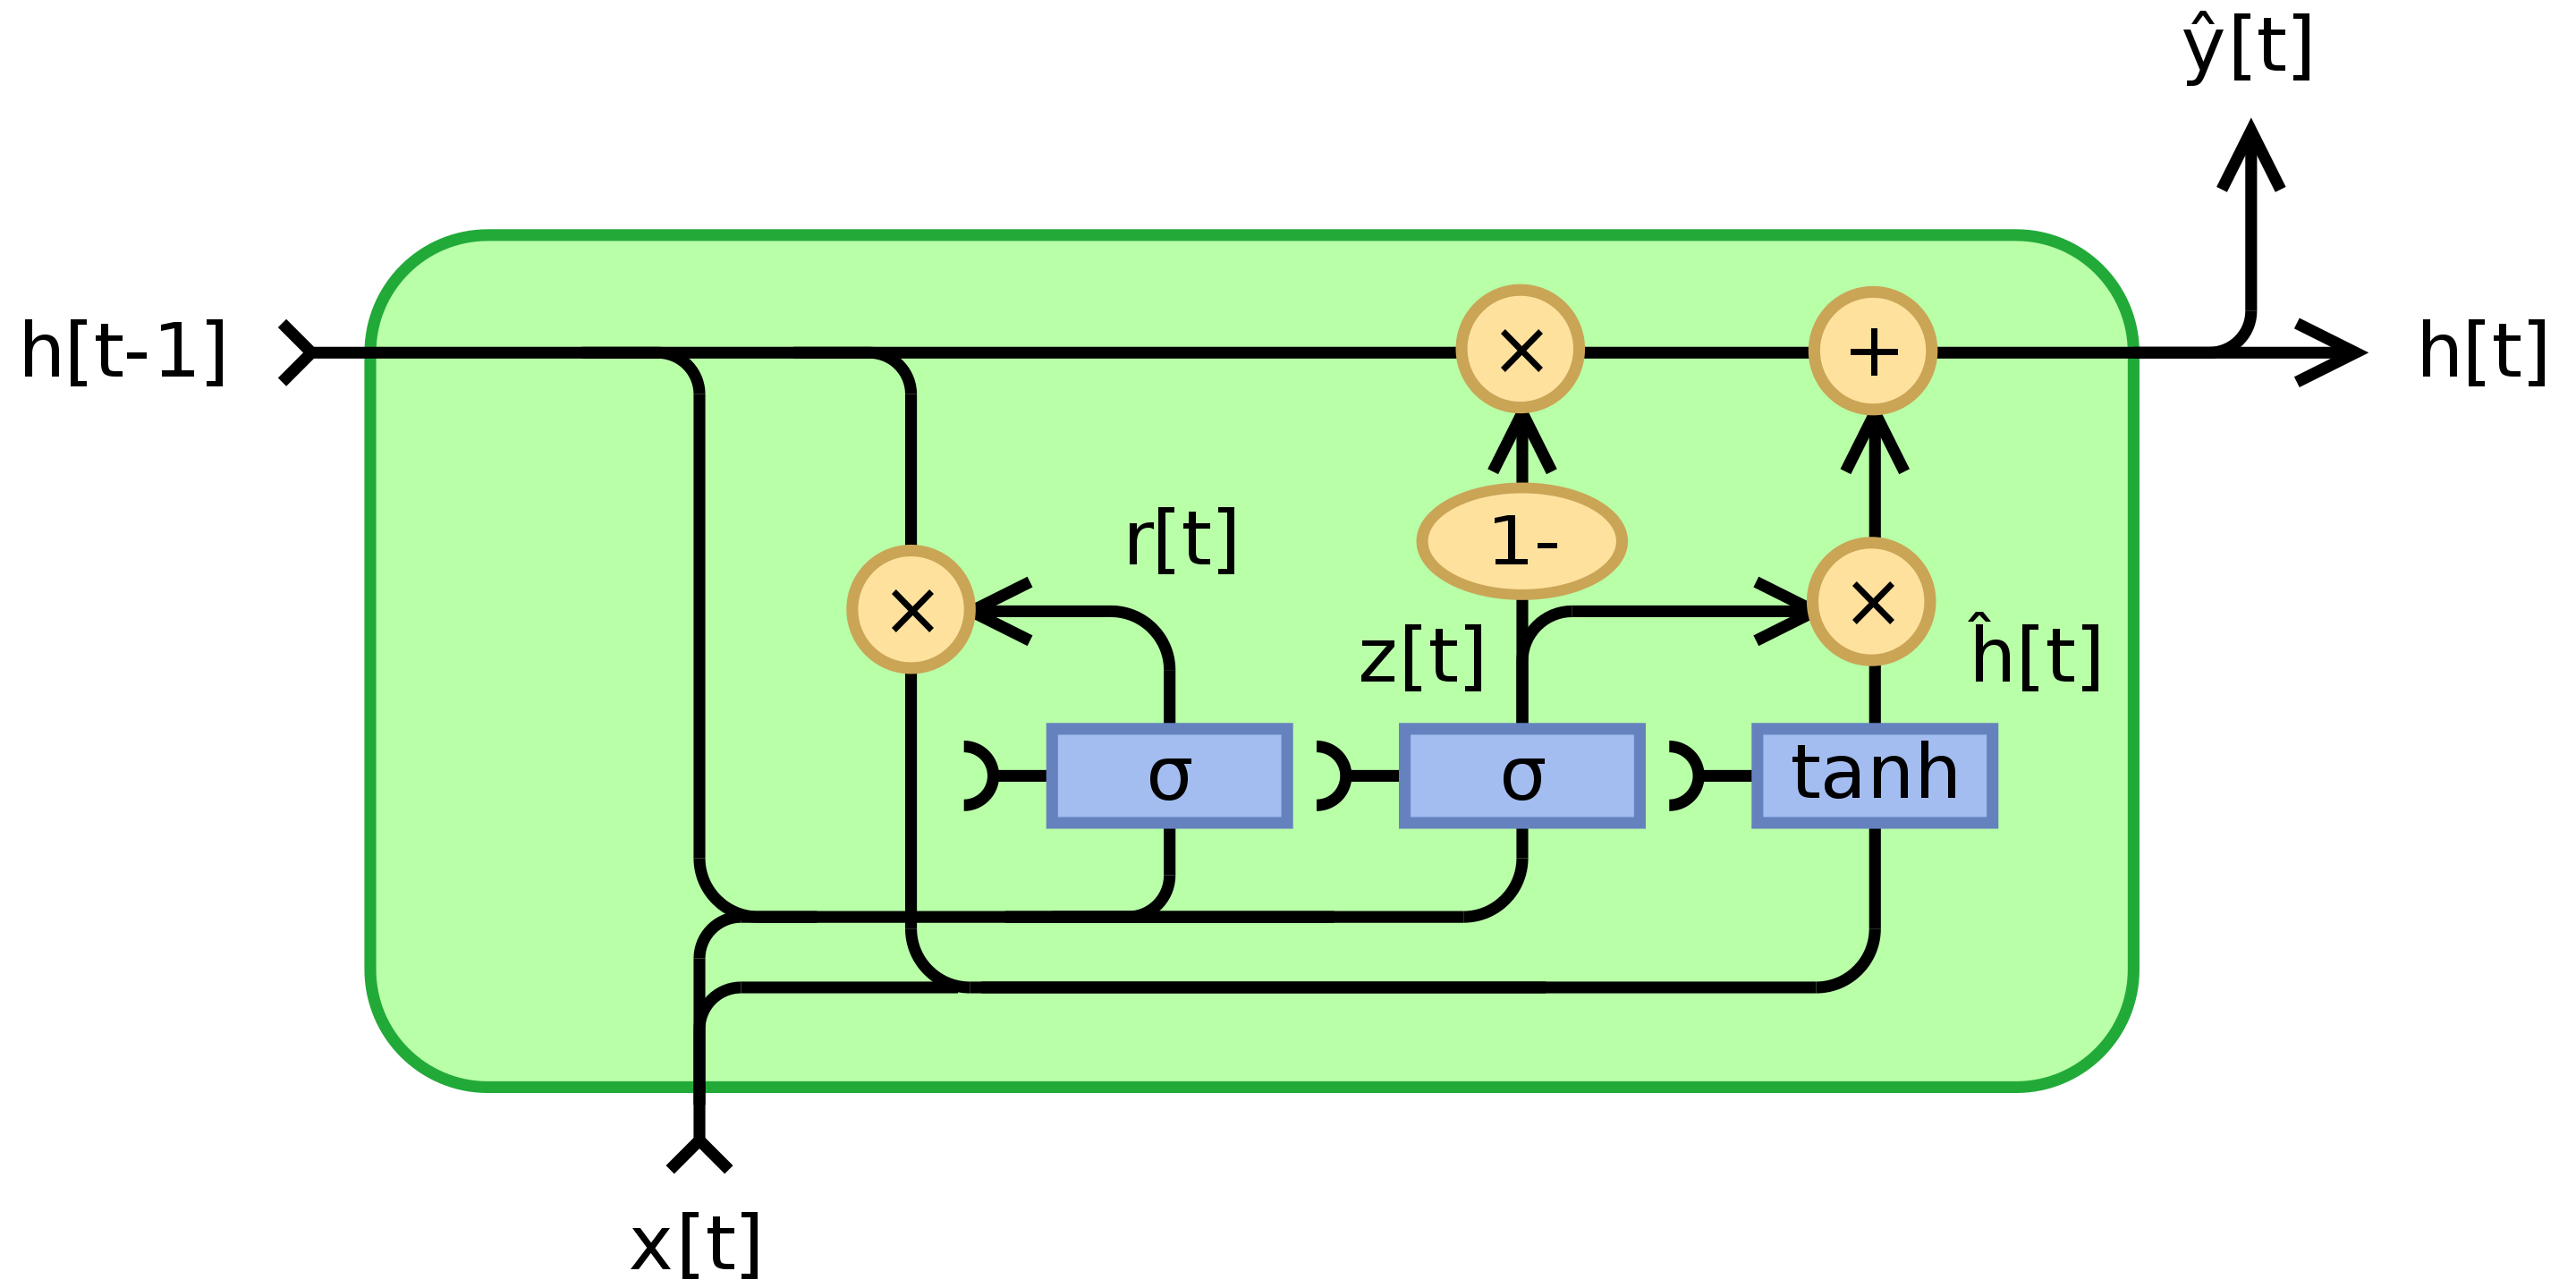

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [35]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(x@self.update_w + state@self.update_u + self.update_b)

            # fill this in
            reset_gate = objax.functional.sigmoid(x@self.reset_w + state@self.reset_u + self.reset_b)
            
            # fill this in
            output_gate = objax.functional.tanh(x@self.output_w + (reset_gate*state)@self.output_u + self.output_b)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

`lax.scan(f, init, xs)` takes 3 parameters, a callable function f, initial parameters for the function f, and a set of axes to iterate over.

When consdering GRUs, each block is a function of the previous state so to compute the output from a series of blocks, we must loop over each block in-order and update their outputs respectively. lax.scan replaces this requirement by iterating over the blocks for us and keeping track of the state to carry over to the next block.

Our function f is `scan_op(state, x)` which defines the behaviour of a block given the previous hidden values `state` and the input `x`. 

We also pass on the initial state from `__call__` which is the value to carry between each block. For a GRU, the first block has no previous hidden state so it should be 0.

Finally, we pass the input matrix `x` transposed to be in the correct orietation. Specifically, in our case, is a 3-D matrix so looping over x means taking 2-D matrices. The transpose is required to swap the first two axes as required by how our data is setup.

Consider the following basic example:

I apply `lax.scan` to compute a factorial. In this case, `scan_op` takes the previous state which is the product of the numbers up to that block and returns the product with the current input. For the k-th block and n-factorial, the state is the the product of the numbers from n to k = factorial from n to k. During computation, it takes the current state which is the factorial from n to k+1, then multiplies it with the input of the current block to update the state to be the factorial from n to k.

The hidden layer outputs are not important to me so my scan function returns 0 as the second element of the tuple.

As seen by the output, applying lax.scan on varying numbers produces the output from the last block and an array of the hidden layer outputs. Since I chose to output 0 for the hidden layer outputs, it is just an array of 0s. Selecting the 0th element of lax.scan as used in the GRU code returns the output from the last block.

In [36]:
def my_scan_op(state, x):
    return state*x,0
    
def factorial(start):
    initial_state = 1
    x = np.array([_ for _ in range(start,0,-1)])

    return lax.scan(my_scan_op, initial_state, x)
  
print('Factorial of 5:\t',factorial(5), '\t', factorial(5)[0])
print('Factorial of 4:\t',factorial(4), '\t', factorial(4)[0])
print('Factorial of 3:\t',factorial(3), '\t\t', factorial(3)[0])
print('Factorial of 2:\t',factorial(2), '\t\t', factorial(2)[0])
print('Factorial of 1:\t',factorial(1), '\t\t\t', factorial(1)[0])

Factorial of 5:	 (DeviceArray(120, dtype=int32), DeviceArray([0, 0, 0, 0, 0], dtype=int32, weak_type=True)) 	 120
Factorial of 4:	 (DeviceArray(24, dtype=int32), DeviceArray([0, 0, 0, 0], dtype=int32, weak_type=True)) 	 24
Factorial of 3:	 (DeviceArray(6, dtype=int32), DeviceArray([0, 0, 0], dtype=int32, weak_type=True)) 		 6
Factorial of 2:	 (DeviceArray(2, dtype=int32), DeviceArray([0, 0], dtype=int32, weak_type=True)) 		 2
Factorial of 1:	 (DeviceArray(1, dtype=int32), DeviceArray([0], dtype=int32, weak_type=True)) 			 1


# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [37]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [38]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [39]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [40]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()

gv = objax.GradValues(loss_function, gru_rnn.vars())

@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss

train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())

The next function is a helper for computing the accuracy.

In [41]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [42]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [43]:
train_acc_epoch = []
val_acc_epoch = []
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
      train_acc_epoch.append(accuracy(training_data))
     
      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
      val_acc_epoch.append(accuracy(validation_data))
     
      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], train_acc_epoch[-1]*100, val_acc_epoch[-1]*100))

In [44]:
train()

Epoch 0001  Training Loss 172.57 Validation Loss 171.05 Training Accuracy 58.68 Validation Accuracy 57.44
Epoch 0002  Training Loss 168.10 Validation Loss 159.46 Training Accuracy 64.72 Validation Accuracy 64.22
Epoch 0003  Training Loss 162.17 Validation Loss 159.42 Training Accuracy 64.07 Validation Accuracy 62.48
Epoch 0004  Training Loss 154.49 Validation Loss 144.11 Training Accuracy 71.40 Validation Accuracy 69.92
Epoch 0005  Training Loss 149.05 Validation Loss 143.84 Training Accuracy 70.57 Validation Accuracy 68.46
Epoch 0006  Training Loss 144.38 Validation Loss 152.24 Training Accuracy 69.41 Validation Accuracy 67.96
Epoch 0007  Training Loss 140.70 Validation Loss 178.50 Training Accuracy 59.36 Validation Accuracy 59.16
Epoch 0008  Training Loss 138.37 Validation Loss 124.63 Training Accuracy 77.53 Validation Accuracy 76.32
Epoch 0009  Training Loss 136.74 Validation Loss 139.34 Training Accuracy 76.78 Validation Accuracy 75.26
Epoch 0010  Training Loss 133.87 Validation Lo

In [45]:
print(accuracy(test_data)*100)

84.28


**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

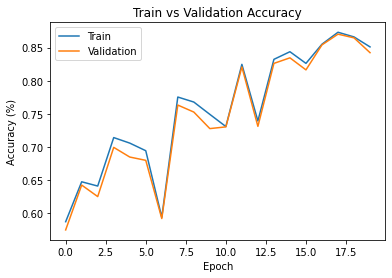

In [46]:
plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

The generalization gap between test and training is the accuracy difference between the two. After 20 epochs, the training accuracy is greater by 0.7.

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [47]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [48]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [49]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()

gv2 = objax.GradValues(loss_function, gru_rnn2.vars())

@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss

train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [50]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [51]:
train_acc_epoch = []
val_acc_epoch = []
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
      train_acc_epoch.append(accuracy(training_data))
     
      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
      val_acc_epoch.append(accuracy(validation_data))
     
      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], train_acc_epoch[-1]*100, val_acc_epoch[-1]*100))

In [52]:
train()

Epoch 0001  Training Loss 118.33 Validation Loss 78.71 Training Accuracy 87.81 Validation Accuracy 86.52
Epoch 0002  Training Loss 74.13 Validation Loss 74.57 Training Accuracy 89.66 Validation Accuracy 87.10
Epoch 0003  Training Loss 67.56 Validation Loss 69.68 Training Accuracy 90.52 Validation Accuracy 87.94
Epoch 0004  Training Loss 63.26 Validation Loss 69.25 Training Accuracy 91.11 Validation Accuracy 87.94
Epoch 0005  Training Loss 60.24 Validation Loss 69.47 Training Accuracy 91.75 Validation Accuracy 88.22
Epoch 0006  Training Loss 58.17 Validation Loss 69.98 Training Accuracy 92.43 Validation Accuracy 88.08
Epoch 0007  Training Loss 54.53 Validation Loss 75.60 Training Accuracy 91.69 Validation Accuracy 86.98
Epoch 0008  Training Loss 52.18 Validation Loss 74.66 Training Accuracy 93.15 Validation Accuracy 87.90
Epoch 0009  Training Loss 48.71 Validation Loss 74.06 Training Accuracy 93.80 Validation Accuracy 87.30
Epoch 0010  Training Loss 46.10 Validation Loss 80.32 Training 

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

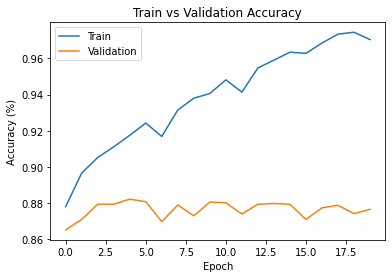

In [53]:
plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [54]:
print(accuracy(test_data)*100)

86.979996


Generalization gap is 10.06.

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam Optimizer:

Adam uses the first and second moments of the gradient to update weights. Firstly, the gradient is used to update the first and second moment vectors with a given rate of decay. Since the moment vectors integrate gradient information from past iterations, the rate of decay ensures that older gradients decrease in significance over time. This approach can be interpreted as an exponential moving average of the gradients where the significance of older gradients undergo exponential decay. Then, these moment vectors are bias-corrected because they are initialized as vectors of 0 so they are initially biased towards 0. Finally, the bias corrected moments are used to update the weight with the conventional learning rate. Hyperparameters are $\beta_1$, $\beta_2$, $ϵ$, and the normal learning rate.

Update First Momentum: $v_k = β_1 v_{k-1} + (1-β_1)∇f$

Update Second Momentum: $s_k = β_2 s_{k-1} + (1-β_2)(∇f)^2$

Bias-Correct First Momentum: $\hat{v_k} = \frac{v_k}{(1-β_1^k)}$

Bias-Correct Second Momentum: $\hat{s_k} = \frac{s_k}{(1-β_2^k)}$

Weight Update: $w_k = w_{k-1} - \eta \frac{\hat{v_k}}{\sqrt{\hat{s_k}}+ϵ}$

$ϵ$ is a small value (10e^8) to ensure there's not division by zero numerical instability.

Compared to SGD, SGD computes the gradient for a subset of examples in the batch so as to reduce the amount of computation of computing the gradient for all the training examples. SGD uses the current gradient only so it does not consider higher order moments compared to Adam.

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [75]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [76]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [77]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()

gv3 = objax.GradValues(loss_function, gru_rnn3.vars())

@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss

train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [78]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [79]:
train_acc_epoch = []
val_acc_epoch = []
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
    cur_patience = 0
    max_validation_accuracy = 0
    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(messages_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, messages_train.shape[0], BATCH):
            batch = train_indices[it:it+BATCH]
            avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
        train_acc_epoch.append(accuracy((messages_train, labels_train)))
        
        # run validation
        val_indices = np.arange(len(messages_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, messages_valid.shape[0], BATCH):
            batch = val_indices[it:it+BATCH]
            avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_acc_epoch.append(accuracy((messages_valid, labels_valid)))
        
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], train_acc_epoch[-1]*100, val_acc_epoch[-1]*100))

        #keep track of best model
        if val_acc_epoch[-1]*100 > max_validation_accuracy:
            max_validation_accuracy = val_acc_epoch[-1]*100
            print('Test Accuracy for Best Model so Far:', accuracy(test_data)*100)

        #check for early stopping
        #create base case for first epoch
        if len(val_acc_epoch) == 1:
            continue
        elif val_acc_epoch[-1] <= val_acc_epoch[-2]:
            cur_patience += 1
        else:
            cur_patience = 0
        
        if cur_patience >= max_patience_window:
            return

In [80]:
train()

Epoch 0001  Training Loss 119.78 Validation Loss 81.18 Training Accuracy 87.55 Validation Accuracy 86.36
Test Accuracy for Best Model so Far: 86.76
Epoch 0002  Training Loss 74.15 Validation Loss 72.43 Training Accuracy 89.56 Validation Accuracy 87.40
Test Accuracy for Best Model so Far: 87.46
Epoch 0003  Training Loss 67.90 Validation Loss 68.49 Training Accuracy 90.57 Validation Accuracy 88.22
Test Accuracy for Best Model so Far: 88.22
Epoch 0004  Training Loss 63.42 Validation Loss 68.28 Training Accuracy 91.26 Validation Accuracy 88.12
Epoch 0005  Training Loss 60.42 Validation Loss 73.33 Training Accuracy 90.36 Validation Accuracy 87.22
Epoch 0006  Training Loss 57.81 Validation Loss 71.47 Training Accuracy 91.97 Validation Accuracy 88.20
Epoch 0007  Training Loss 54.48 Validation Loss 71.63 Training Accuracy 92.62 Validation Accuracy 88.04
Epoch 0008  Training Loss 51.97 Validation Loss 78.00 Training Accuracy 92.23 Validation Accuracy 87.74
Epoch 0009  Training Loss 49.30 Valida

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The best validation accuracy is 88.22 which occurs at epoch 3. The test accuracy of that model was 88.22.